# Solutions 9 - Examples in Compressive Sensing

## Assignment 1

We shall solve Sudoku puzzles using two approaches:

1. The approach from  the file 
[sudoku.jl](https://github.com/JuliaOpt/JuMP.jl/blob/master/examples/sudoku.jl) from the package
[JuMP.jl](https://github.com/JuliaOpt/JuMP.jl).
This method solves Sudoku puzzles using Mixed Integer Programming from the package [GLPK.jl](https://github.com/JuliaOpt/GLPK.jl) which needs to be installed beforehand.
2. We model sudoku problem as a compressive sensing problem and solve it with linear programming.

In [1]:
# Read the sudoku
using CSV

In [2]:
s=CSV.read("files/sudoku.csv",header=0)

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,3,1,0,0,5,8,0,0,4
2,0,0,9,3,2,0,0,0,0
3,0,2,5,1,0,4,0,9,0
4,0,0,0,0,0,0,3,8,9
5,0,0,8,0,0,0,5,0,0
6,5,4,6,0,0,0,0,0,0
7,0,8,0,2,0,3,6,5,0
8,0,0,0,0,7,1,4,0,0
9,7,0,0,4,8,0,0,2,1


In [3]:
s=convert(Matrix,s)

9×9 Array{Int64,2}:
 3  1  0  0  5  8  0  0  4
 0  0  9  3  2  0  0  0  0
 0  2  5  1  0  4  0  9  0
 0  0  0  0  0  0  3  8  9
 0  0  8  0  0  0  5  0  0
 5  4  6  0  0  0  0  0  0
 0  8  0  2  0  3  6  5  0
 0  0  0  0  7  1  4  0  0
 7  0  0  4  8  0  0  2  1

In [4]:
# Function to print sudoku from sudoku.jl
function print_sudoku(sudoku::Matrix)
    # println("Sudoku:")
    println("[-----------------------]")
    for row in 1:9
        print("[ ")
        for col in 1:9
            print(sudoku[row, col], " ")
            if col % 3 == 0 && col < 9
                print("| ")
            end
        end
        println("]")
        if row % 3 == 0
            println("[-----------------------]")
        end
    end
end

print_sudoku (generic function with 1 method)

In [5]:
print_sudoku(s)

[-----------------------]
[ 3 1 0 | 0 5 8 | 0 0 4 ]
[ 0 0 9 | 3 2 0 | 0 0 0 ]
[ 0 2 5 | 1 0 4 | 0 9 0 ]
[-----------------------]
[ 0 0 0 | 0 0 0 | 3 8 9 ]
[ 0 0 8 | 0 0 0 | 5 0 0 ]
[ 5 4 6 | 0 0 0 | 0 0 0 ]
[-----------------------]
[ 0 8 0 | 2 0 3 | 6 5 0 ]
[ 0 0 0 | 0 7 1 | 4 0 0 ]
[ 7 0 0 | 4 8 0 | 0 2 1 ]
[-----------------------]


In [6]:
using JuMP
using GLPK

We modify the function `example_sudoku()` from the file [sudoku.jl](https://github.com/JuliaOpt/JuMP.jl/blob/master/examples/sudoku.jl) so that we can use it directly on the array.

In [7]:
?Model

search: Model ModelMode model_string copy_model owner_model direct_model



```
Model
```

A mathematical model of an optimization problem.

---

```
Model(; caching_mode::MOIU.CachingOptimizerMode=MOIU.AUTOMATIC)
```

Return a new JuMP model without any optimizer; the model is stored the model in a cache. The mode of the `CachingOptimizer` storing this cache is `caching_mode`. Use [`set_optimizer`](@ref) to set the optimizer before calling [`optimize!`](@ref).

---

```
Model(optimizer_factory;
      caching_mode::MOIU.CachingOptimizerMode=MOIU.AUTOMATIC,
      bridge_constraints::Bool=true)
```

Return a new JuMP model with the provided optimizer and bridge settings. This function is equivalent to:

```julia
    model = Model()
    set_optimizer(model, optimizer_factory,
                  bridge_constraints=bridge_constraints)
    return model
```

See [`set_optimizer`](@ref) for the description of the `optimizer_factory` and `bridge_constraints` arguments.

## Examples

The following creates a model with the optimizer set to `Ipopt`:

```julia
model = Model(Ipopt.Optimizer)
```


In [8]:
function solve_sudoku(sudoku::Matrix)
    initial_grid=sudoku
    model = Model(GLPK.Optimizer) #GLPK
    
    @variable(model, x[1:9, 1:9, 1:9], Bin)

    @constraints(model, begin
        # Constraint 1 - Only one value appears in each cell
        cell[i in 1:9, j in 1:9], sum(x[i, j, :]) == 1
        # Constraint 2 - Each value appears in each row once only
        row[i in 1:9, k in 1:9], sum(x[i, :, k]) == 1
        # Constraint 3 - Each value appears in each column once only
        col[j in 1:9, k in 1:9], sum(x[:, j, k]) == 1
        # Constraint 4 - Each value appears in each 3x3 subgrid once only
        subgrid[i=1:3:7, j=1:3:7, val=1:9], sum(x[i:i + 2, j:j + 2, val]) == 1
    end)

    # Initial solution
    for row in 1:9, col in 1:9
        if initial_grid[row, col] != 0
            @constraint(model, x[row, col, initial_grid[row, col]] == 1)
        end
    end

    # Solve it
    JuMP.optimize!(model)

    term_status = JuMP.termination_status(model)
    primal_status = JuMP.primal_status(model)
    is_optimal = term_status == MOI.OPTIMAL

    # Check solution
    if is_optimal
        mip_solution = JuMP.value.(x)
        sol = zeros(Int, 9, 9)
        for row in 1:9, col in 1:9, val in 1:9
            if mip_solution[row, col, val] >= 0.9
                sol[row, col] = val
            end
        end
        return sol
    else
        error("The solver did not find an optimal solution.")
    end
end

solve_sudoku (generic function with 1 method)

In [9]:
# Solve the sudoku with the method from the file 
# MIP (Mixed Integer Programing) from GLPK
sol=solve_sudoku(s)

9×9 Array{Int64,2}:
 3  1  7  9  5  8  2  6  4
 4  6  9  3  2  7  8  1  5
 8  2  5  1  6  4  7  9  3
 2  7  1  6  4  5  3  8  9
 9  3  8  7  1  2  5  4  6
 5  4  6  8  3  9  1  7  2
 1  8  4  2  9  3  6  5  7
 6  9  2  5  7  1  4  3  8
 7  5  3  4  8  6  9  2  1

In [10]:
# Nicer print
print_sudoku(sol)

[-----------------------]
[ 3 1 7 | 9 5 8 | 2 6 4 ]
[ 4 6 9 | 3 2 7 | 8 1 5 ]
[ 8 2 5 | 1 6 4 | 7 9 3 ]
[-----------------------]
[ 2 7 1 | 6 4 5 | 3 8 9 ]
[ 9 3 8 | 7 1 2 | 5 4 6 ]
[ 5 4 6 | 8 3 9 | 1 7 2 ]
[-----------------------]
[ 1 8 4 | 2 9 3 | 6 5 7 ]
[ 6 9 2 | 5 7 1 | 4 3 8 ]
[ 7 5 3 | 4 8 6 | 9 2 1 ]
[-----------------------]


The formulation from [P. Babu, K. Pelckmans, P. Stoica and J. Li, Linear Systems, Sparse Solutions, and Sudoku][BPSL10] is essentially the same.
We first ceate the constraints matrix for rows, columns, boxes and cells (all except clues).

[BPSL10]: http://people.math.yorku.ca/~chensy/sudoku.pdf "Prabhu Babu, Kristiaan Pelckmans, Petre Stoica and Jian Li, 'Sparse Solutions, and Sudoku',  IEEE Signal Processing Letters, 17(1) (2010) 40-42."

In [11]:
# Convenience function
unblock(A) = mapreduce(identity, hcat, [mapreduce(identity, vcat, A[:,i]) 
        for i = 1:size(A,2)])
using Plots
using LinearAlgebra

In [12]:
n=9
n2=81
n3=729
# Row constraints
I9=Array{Int}(I,9,9)
Rows=[repeat(I9,1,9) zeros(Int,n,n3-n2)]
for i=1:8
    Rows=vcat(Rows,[zeros(Int,n,i*n2) repeat(I9,1,9) zeros(Int,n,(n-i-1)*n2)])
end
# Column constraints
Cols=repeat([I9 zeros(Int,9,72)],1,9)
for i=1:8
    Cols=vcat(Cols,[zeros(Int,9,9*i) repeat([I9 zeros(Int,9,72)],1,8) I9 zeros(Int,9,72-9*i)])
end
# Box constraints
z9=zeros(Int,9,9)
Box=[z9 for i=1:n, j=1:n2]
for i=1:3, j=0:2
    Box[i,9*j+1+3*(i-1):9*j+3+3*(i-1)]=[I9 for k=1:3]
end
for i=1:3, j=0:2
    Box[i+3,27+9*j+1+3*(i-1):27+9*j+3+3*(i-1)]=[I9 for k=1:3]
end
for i=1:3, j=0:2
    Box[i+6,54+9*j+1+3*(i-1):54+9*j+3+3*(i-1)]=[I9 for k=1:3]
end
Box=unblock(Box)
# Cell constraints
Cell=zeros(Int,n2,n3)
for i=1:n2
    Cell[i,9*(i-1)+1:9*i]=ones(Int,1,9)
end
C=vcat(Rows,Cols,Box,Cell)

324×729 Array{Int64,2}:
 1  0  0  0  0  0  0  0  0  1  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  

In [15]:
import Plots.spy
spy(A)=heatmap(A,yflip=true,color=:heat)

spy (generic function with 2 methods)

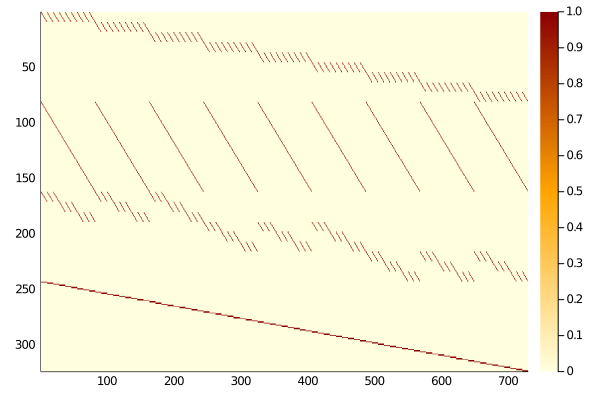

In [16]:
spy(C)

In [17]:
using MathProgBase
using GLPKMathProgInterface

In [18]:
function solve_sudoku(sudoku::Matrix, C::Matrix)
    # Clue constraints
    clue=count(!iszero,sudoku)
    Clue=zeros(Int,clue,n3)
    ind=findall(!iszero,sudoku'[:])
    for i=1:clue
        Clue[i,9*(ind[i]-1)+sudoku'[ind[i]]]=1
    end
    C=vcat(C,Clue)
    # Solve it
    l1=linprog(ones(n3),C,'=',ones(size(C,1)),0,Inf,GLPKSolverLP())
    # Reconstruct the solution
    if l1.status == :Infeasible
        error("No solution found!")
    else
        return Matrix(reshape(map(Int,round.(collect(1:9)'*reshape(l1.sol,9,81))),9,9)'), l1.status
    end
end

solve_sudoku (generic function with 2 methods)

In [19]:
@time sol₁,status=solve_sudoku(s,C)

  1.736646 seconds (3.22 M allocations: 161.931 MiB, 3.78% gc time)


([3 1 … 6 4; 4 6 … 1 5; … ; 6 9 … 3 8; 7 5 … 2 1], :Optimal)

In [20]:
print_sudoku(sol₁)

[-----------------------]
[ 3 1 7 | 9 5 8 | 2 6 4 ]
[ 4 6 9 | 3 2 7 | 8 1 5 ]
[ 8 2 5 | 1 6 4 | 7 9 3 ]
[-----------------------]
[ 2 7 1 | 6 4 5 | 3 8 9 ]
[ 9 3 8 | 7 1 2 | 5 4 6 ]
[ 5 4 6 | 8 3 9 | 1 7 2 ]
[-----------------------]
[ 1 8 4 | 2 9 3 | 6 5 7 ]
[ 6 9 2 | 5 7 1 | 4 3 8 ]
[ 7 5 3 | 4 8 6 | 9 2 1 ]
[-----------------------]


In [21]:
sol-sol₁

9×9 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0

Let us try two harder puzzles.

In [22]:
s=CSV.read("files/sudokuhard.csv",header=0)
s=convert(Matrix,s)
print_sudoku(s)

[-----------------------]
[ 5 4 0 | 0 0 3 | 1 0 0 ]
[ 0 8 0 | 4 0 1 | 0 0 6 ]
[ 0 0 0 | 5 0 0 | 0 2 0 ]
[-----------------------]
[ 0 7 0 | 0 0 0 | 6 0 0 ]
[ 0 0 4 | 0 0 0 | 9 0 0 ]
[ 0 0 6 | 0 0 0 | 0 3 0 ]
[-----------------------]
[ 0 5 0 | 0 0 4 | 0 0 0 ]
[ 1 0 0 | 2 0 8 | 0 7 0 ]
[ 0 0 2 | 7 0 0 | 0 1 9 ]
[-----------------------]


In [23]:
@time sol=solve_sudoku(s)
print_sudoku(sol)

  1.188648 seconds (1.97 M allocations: 97.386 MiB, 14.16% gc time)
[-----------------------]
[ 5 4 7 | 6 2 3 | 1 9 8 ]
[ 2 8 9 | 4 7 1 | 3 5 6 ]
[ 6 3 1 | 5 8 9 | 7 2 4 ]
[-----------------------]
[ 8 7 5 | 3 9 2 | 6 4 1 ]
[ 3 2 4 | 1 5 6 | 9 8 7 ]
[ 9 1 6 | 8 4 7 | 5 3 2 ]
[-----------------------]
[ 7 5 8 | 9 1 4 | 2 6 3 ]
[ 1 9 3 | 2 6 8 | 4 7 5 ]
[ 4 6 2 | 7 3 5 | 8 1 9 ]
[-----------------------]


In [24]:
@time sol₁,status=solve_sudoku(s,C)
print_sudoku(sol₁), status

  0.029227 seconds (3.31 k allocations: 2.352 MiB)
[-----------------------]
[ 5 4 7 | 6 2 3 | 1 9 8 ]
[ 2 8 9 | 4 7 1 | 3 5 6 ]
[ 6 3 1 | 5 8 9 | 7 2 4 ]
[-----------------------]
[ 8 7 5 | 3 9 2 | 6 4 1 ]
[ 3 2 4 | 1 5 6 | 9 8 7 ]
[ 9 1 6 | 8 4 7 | 5 3 2 ]
[-----------------------]
[ 7 5 8 | 9 1 4 | 2 6 3 ]
[ 1 9 3 | 2 6 8 | 4 7 5 ]
[ 4 6 2 | 7 3 5 | 8 1 9 ]
[-----------------------]


(nothing, :Optimal)

In [25]:
# New puzzle
s=[ 0 0 0 6 0 1 4 0 0;
    9 0 0 2 4 0 7 0 0;
    0 0 3 0 0 0 0 0 9;
    0 6 0 0 0 5 0 0 0;
    3 1 0 0 0 0 0 0 4;
    0 0 0 7 0 0 0 6 0;
    2 0 0 0 0 0 9 0 0;
    4 0 0 0 6 2 0 0 1;
    0 0 1 9 0 8 0 0 0]
print_sudoku(s)

[-----------------------]
[ 0 0 0 | 6 0 1 | 4 0 0 ]
[ 9 0 0 | 2 4 0 | 7 0 0 ]
[ 0 0 3 | 0 0 0 | 0 0 9 ]
[-----------------------]
[ 0 6 0 | 0 0 5 | 0 0 0 ]
[ 3 1 0 | 0 0 0 | 0 0 4 ]
[ 0 0 0 | 7 0 0 | 0 6 0 ]
[-----------------------]
[ 2 0 0 | 0 0 0 | 9 0 0 ]
[ 4 0 0 | 0 6 2 | 0 0 1 ]
[ 0 0 1 | 9 0 8 | 0 0 0 ]
[-----------------------]


In [26]:
# Mixed integer programming is fine,
@time sol=solve_sudoku(s)
print_sudoku(sol)

  0.040713 seconds (51.21 k allocations: 3.077 MiB)
[-----------------------]
[ 7 5 2 | 6 9 1 | 4 8 3 ]
[ 9 8 6 | 2 4 3 | 7 1 5 ]
[ 1 4 3 | 5 8 7 | 6 2 9 ]
[-----------------------]
[ 8 6 9 | 4 1 5 | 2 3 7 ]
[ 3 1 7 | 8 2 6 | 5 9 4 ]
[ 5 2 4 | 7 3 9 | 1 6 8 ]
[-----------------------]
[ 2 3 8 | 1 7 4 | 9 5 6 ]
[ 4 9 5 | 3 6 2 | 8 7 1 ]
[ 6 7 1 | 9 5 8 | 3 4 2 ]
[-----------------------]


In [27]:
# But!
@time sol₁,status=solve_sudoku(s,C)
print_sudoku(sol₁), status

  0.031154 seconds (3.30 k allocations: 2.341 MiB)
[-----------------------]
[ 6 4 5 | 6 9 1 | 4 6 3 ]
[ 9 6 6 | 2 4 3 | 7 1 6 ]
[ 1 4 3 | 5 8 7 | 6 2 9 ]
[-----------------------]
[ 8 6 6 | 4 1 5 | 3 9 4 ]
[ 3 1 8 | 8 2 6 | 5 8 4 ]
[ 7 3 4 | 7 3 9 | 1 6 5 ]
[-----------------------]
[ 2 8 6 | 1 6 4 | 9 3 6 ]
[ 4 9 6 | 3 6 2 | 8 6 1 ]
[ 6 3 1 | 9 6 8 | 2 4 6 ]
[-----------------------]


(nothing, :Optimal)

We see that the $l_1$ sudoku solution is not always possible.